# Richardson Verfahren

Sei $C$ eine reguläre Matrix und $\alpha\in\mathbb{R}^+$. Dann ist das lineare Gleichungssystem äquivalent zur Fixpunktgleichung

$$x = x + \alpha\, C^{-1}\,(b-A x).$$ (eq:RichardsonFixpunktGleichung)

Daraus ergibt sich die Fixpunkt Iteration, auch *einfache Iteration* oder *Richardson Iteration* genannt:

$$x_{k+1} = x_k \alpha\, C^{-1}\,(b-A x_k)$$

wobei der Startwert $x_0$ gegeben ist.

Sei $x$ eine Lösung von {eq}`eq:RichardsonFixpunktGleichung` und

$$e_k = x_k - x$$

der Iterationsfehler. Dann gilt für den neuen Fehler

$$\begin{split}
e_k & = x_{k+1}-x = x_k + \alpha\, C^{-1} (b - A\,x_k) - x\\
& = (x_k-x) + \alpha\, C^{-1} (A\,x-A\,x_k)\\
& = (\mathbb{1} - \alpha\,C{-1} A)\, (x_k-x)\\
& = (\mathbb{1} - \alpha\,C{-1} A)\, e_k.\\
\end{split}$$

Der neue Fehler ergibt sich durch die Iterationsmatrix oder Fehlerübergangsmatrix

$$M = (\mathbb{1} - \alpha\,C{-1} A)$$

als

$$e_{k+1} = M\, e_k.$$

Sei $\|\cdot\|$ eine beliebige Vektornorm und

$$\|M\|:=\sup_{x\in\mathbb{R}^n}\frac{\|M x\|}{\|x\|}$$

die zugehörige Matrixnorm (Operatornorm vgl. {eq}`eq:operatornorm`). Damit gilt für den neuen Fehler (vgl. {eq}`eq:operatornormungleichung`)

$$\|e_{k+1}\| \le \|M\|\, \|e_k\|.$$

Hinreichend für die Konvergenz ist damit die Existenz einer Matrixnorm mit

$$\|M\|<1.$$

## Vorkonditionierer

Die Matrix $C$ wird **Vorkonditionierer** (**Preconditioner**) genannt. Sie soll zwei Eigenschaften erfüllen:
* Die Matrix-Vektormultiplikation mit $C^{-1}\cdot r$ soll billig sein.
* Die Matrix $C$ soll eine gute Approximation zu $A$ sein.

Zur Wahl der Matrix $C$
* Wählt man zum Beispiel $C = \mathbb{1}$ oder etwas besser $C = \mathop{diag} A$, dann ist die Operation $C^{-1}\cdot r$ sehr billig. Die Approximation $C \approx A$ kann aber schlecht sein.
* Wählt man hingegen $C = A$ und $\alpha = 1$, dann ist die zweite Eigenschaft best-möglich erfüllt:

  $$M = \mathbb{1} - \alpha C^{-1} A = \mathbb{1} - A^{-1}A = 0.$$
  
  Es gilt daher $\|M\| = 0$.
  
  Die Invertierung von $C$ ist jetzt aber genau das ursprüngliche Problem.
  
Ziel ist es Vorkonditionierer mit beiden Eigenschaften zu finden.

## Anwendung

In [9]:
from ngsolve import *
from netgen.geom2d import unit_square
import matplotlib.pyplot as plt
from myst_nb import glue

In [2]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))

In [3]:
fes = H1(mesh, order=1)
u,v = fes.TnT()
a = BilinearForm(grad(u)*grad(v)*dx+10*u*v*dx).Assemble()
f = LinearForm(1*v*dx).Assemble()
gfu = GridFunction(fes)

Dämpfung bestimmen

In [4]:
hv = gfu.vec.CreateVector()
hv2 = gfu.vec.CreateVector()
hv.SetRandom()
hv.data /= Norm(hv)
for k in range(20):
    hv2.data = a.mat * hv
    rho = Norm(hv2)
    print (rho)
    hv.data = 1/rho * hv2

1.538629026957872
4.391521515801403
4.752759992787238
4.9136647856237685
5.02134407136911
5.106999495853635
5.1798894005198886
5.243736682332236
5.300467495941496
5.3512499297896845
5.396855995262281
5.437827483629154
5.474571765713796
5.50742304050225
5.536680751893698
5.562631138786436
5.585556671383157
5.6057376164112
5.6234492652133845
5.638957446110428


Richardson Verfahren anwenden

In [5]:
alpha = 1 / rho
r = f.vec.CreateVector()
gfu.vec[:] = 0
err0 = Norm(f.vec)
its = 0
errs = []
while True:
    r.data = f.vec - a.mat * gfu.vec
    err = Norm(r)
    errs.append(err)
    #print ("iteration", its, "res=", err)
    gfu.vec.data += alpha * r
    if err < 1e-8 * err0 or its > 10000: break
    its = its+1
print ("needed", its, "iterations")

needed 1433 iterations


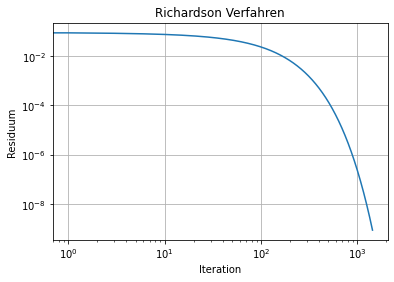

In [10]:
fig, ax = plt.subplots()
ax.loglog(errs)
ax.grid()
ax.set_title('Richardson Verfahren: '+str(its)+' iterationen')
ax.set_xlabel('Iteration')
ax.set_ylabel('Residuum')
glue("FEM_RichardsonVerfahren_fig", fig, display=False)